<a href="https://colab.research.google.com/github/c-mmonteiro/t1-algo-feature/blob/main/Trabaho1_MI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabalho de Feature Enginearing
Disciplina: Algoritmos Baseados em Dados para Problemas de Ciência e Engenharia.

Aluno: Carlos A M Monteiro

# 1. Conjunto de Dados

Gera dados aleatórios e corelacionados para estudo das ferramentas.

In [2]:
import torch as tc
import pandas as pd
import numpy as np

num_amostras = 5000


dados = pd.DataFrame()
dados['x1'] = 6 + tc.randn(num_amostras)
dados['x2'] = [1.5*np.sin(0.002*idx) + n for idx, n in enumerate(dados['x1'])]
dados['x3'] = [0.001*idx+n for idx, n in enumerate(dados['x1'])]
dados['x4'] = [abs(n*np.sin(0.0025*idx))  for idx, n in enumerate(dados['x1'])]
dados['x5'] = [n + float(tc.randn(1)) for idx, n in enumerate(dados['x1'])]
dados['x6'] = [0.0003*idx + 0.8*np.sin(0.0008*idx) + n + float(tc.randn(1)) for idx, n in enumerate(dados['x1'])]
dados['x7'] = tc.rand(num_amostras)
dados['x8'] = [-np.log(n) for idx, n in enumerate(dados['x7'])]
#dados['y'] = [10 + n*np.sin(0.0025*idx) + dados['x7'][idx]*np.sin(0.001*idx) + float(tc.randn(1)) for idx, n in enumerate(dados['x1'])]
dados['y'] = [n + dados['x2'][idx] + dados['x3'][idx] + dados['x4'][idx] + dados['x5'][idx] + dados['x6'][idx] + dados['x7'][idx] + dados['x8'][idx] for idx, n in enumerate(dados['x1'])]

dados

,x1,x2,x3,x4,x5,x6,x7,x8,y
0,6.260271,6.260271,6.260271,0.000000,5.948349,5.184780,0.532488,0.630195,31.076624
1,5.571113,5.574113,5.572113,0.013928,5.839541,3.864820,0.053764,2.923160,29.412552
2,6.815071,6.821071,6.817071,0.034075,7.772885,6.700514,0.383310,0.958911,36.302907
3,5.341686,5.350686,5.344686,0.040062,5.207846,4.376286,0.187014,1.676573,27.524840
4,6.844099,6.856099,6.848099,0.068440,5.748673,5.479708,0.573499,0.555999,32.974615
...,...,...,...,...,...,...,...,...,...
4995,7.674359,6.870954,12.669359,0.604654,7.799037,8.375024,0.950061,0.051229,44.994678
4996,6.051771,5.245834,11.047771,0.461728,5.628362,7.243200,0.841650,0.172392,36.692707
4997,5.076293,4.267828,10.073293,0.374648,5.773208,4.502632,0.887057,0.119846,31.074804
4998,4.647603,3.836612,9.645603,0.331421,4.326846,5.158021,0.932182,0.070227,28.948516


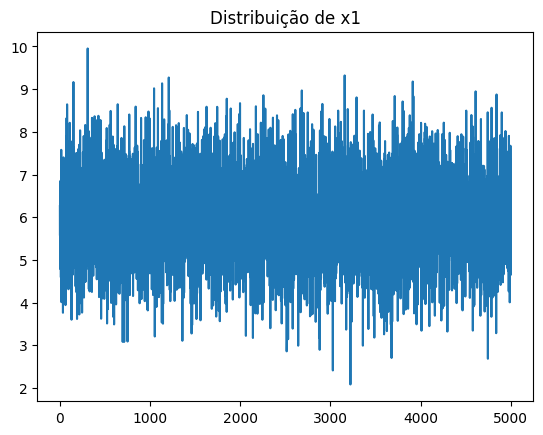

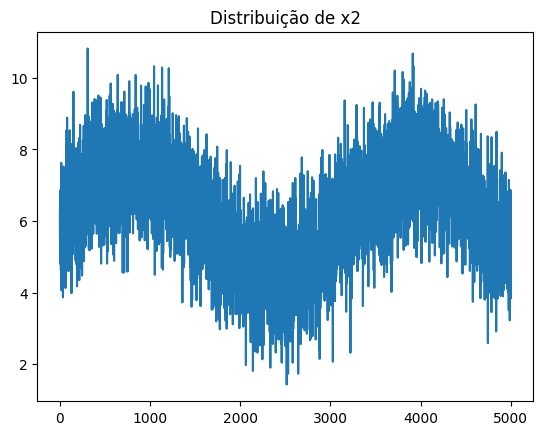

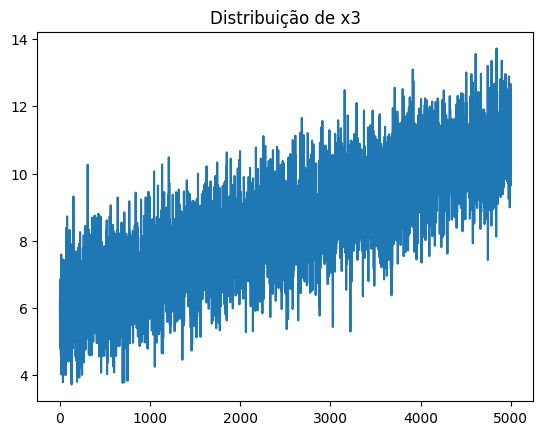

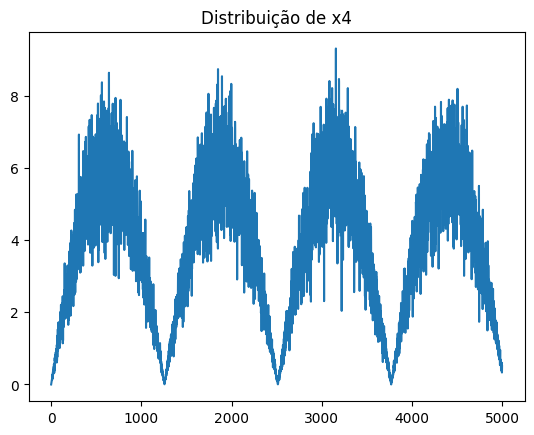

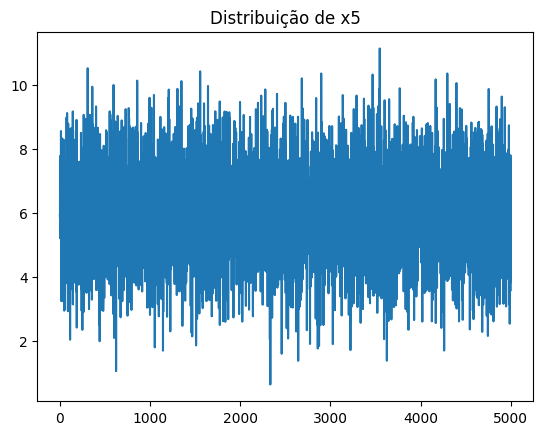

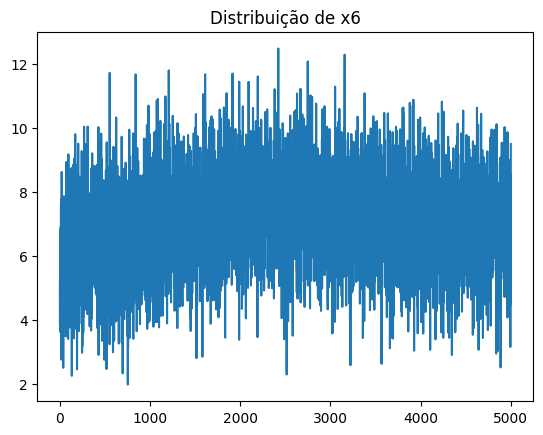

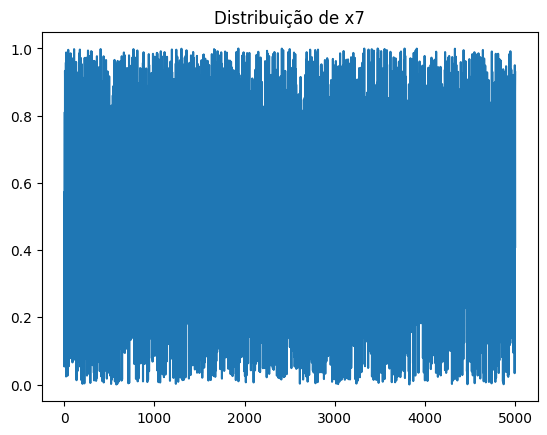

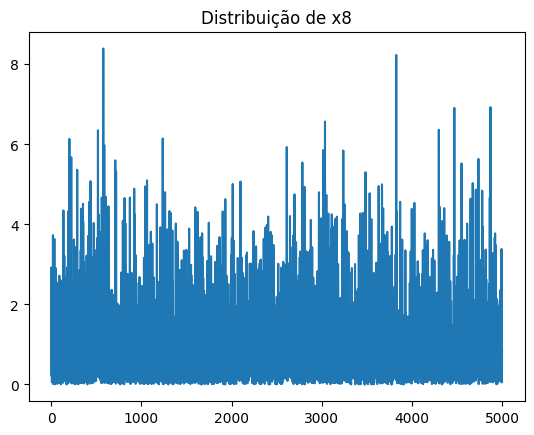

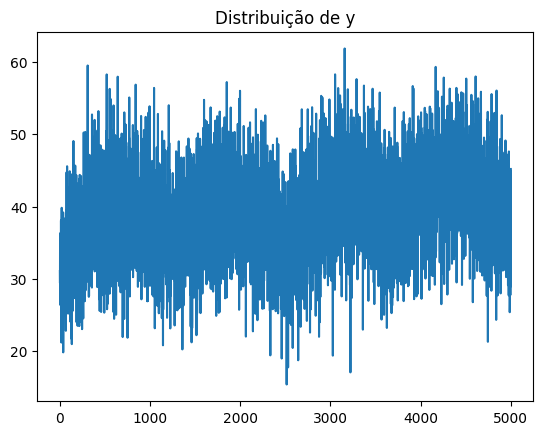

In [3]:
from matplotlib import pyplot as plt

for d in dados.columns:
  plt.figure()
  plt.title(f'Distribuição de {d}')
  dados[d].plot()
  plt.show()

## 1.2 Gráficos dos dados em relação a saída

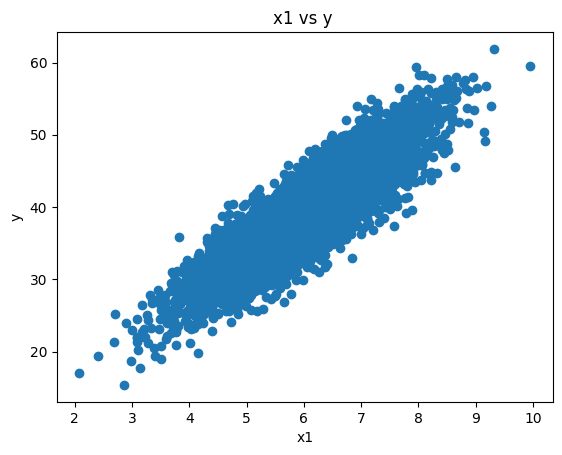

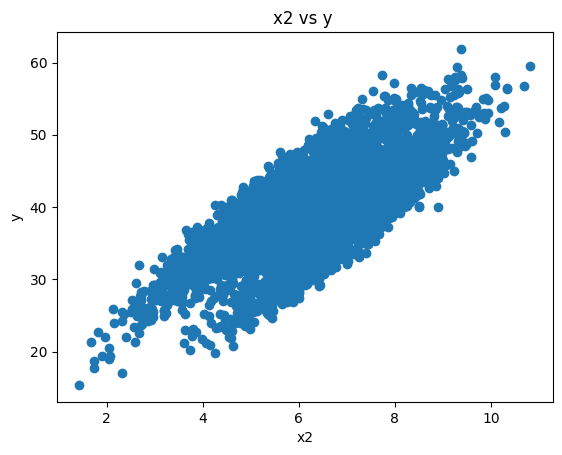

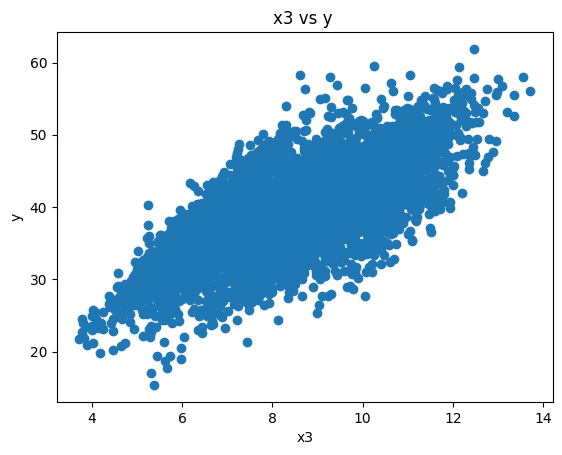

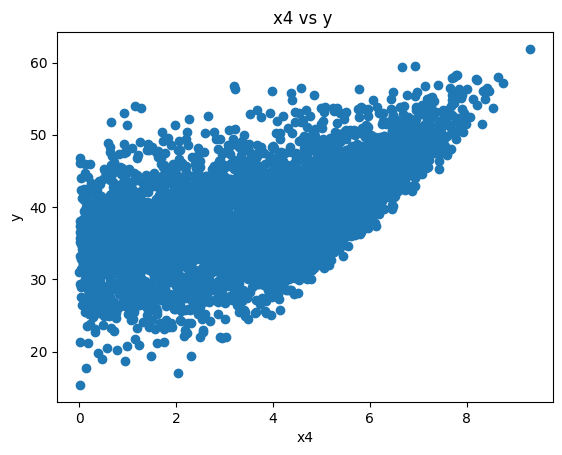

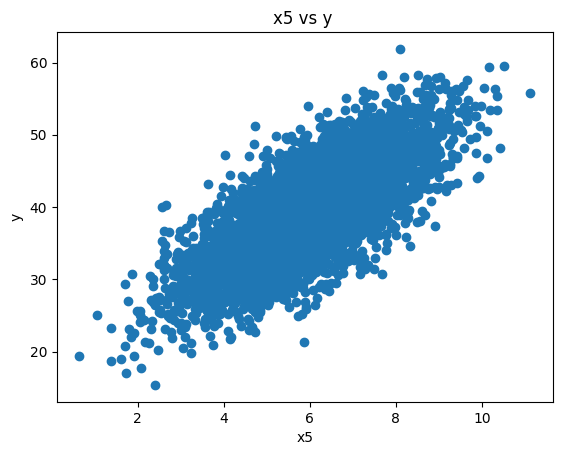

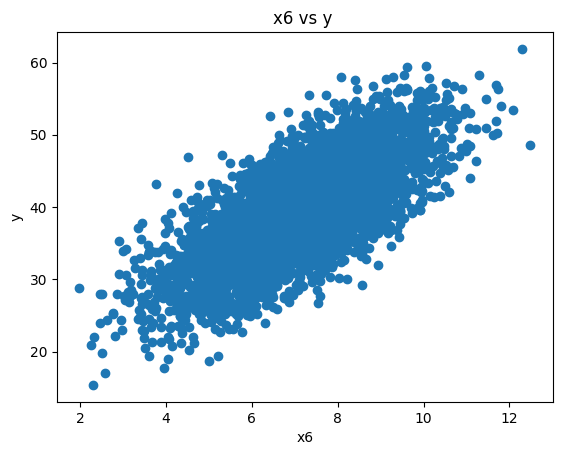

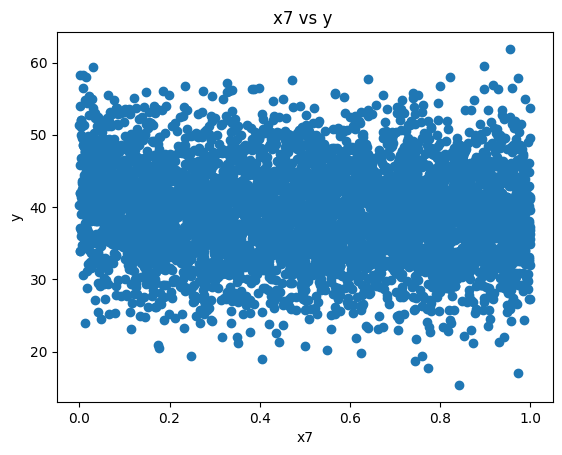

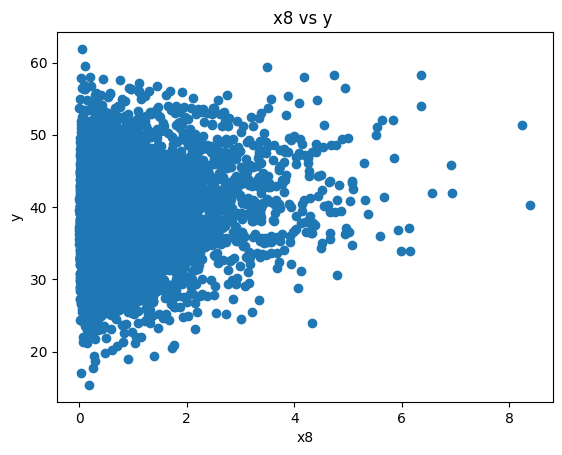

In [4]:
from matplotlib import pyplot as plt
colunas = dados.columns[:-1]
y_col = dados.columns[-1]

for idx, col in enumerate(colunas):
    plt.plot(dados[col], dados[y_col], 'o')
    plt.title(f'{col} vs {y_col} ')
    plt.xlabel(col)
    plt.ylabel(y_col)
    plt.show()

## 1.3 Histograma dos dados

In [5]:
def determina_bins(x, bins_rule = 'fd'):
    if bins_rule == 'classic':
        bins = int(len(x)**0.5)
    elif bins_rule == 'sturges':
        bins = int(np.ceil(np.log2(len(x)) + 1))
    elif bins_rule == 'scott': #ótima para distribuição normal
        bins = int((np.max(x) - np.min(x)) / (3.5 * np.std(x) * len(x)**(-1/3)))
    elif bins_rule == 'fd': #mais robusta para outliers
        bins = int((np.max(x) - np.min(x)) / (2 * (np.percentile(x, 75) - np.percentile(x, 25)) * len(x)**(-1/3)))

    return bins

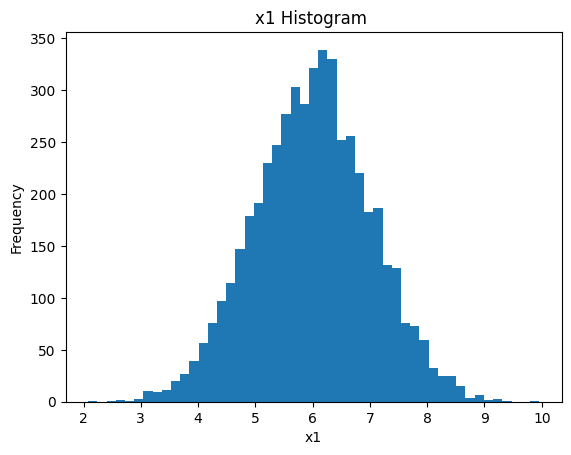

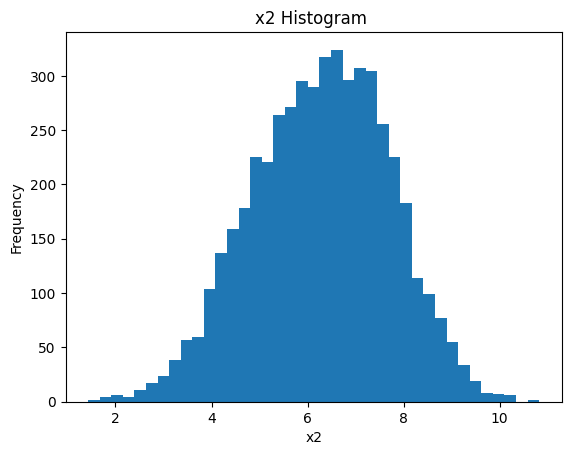

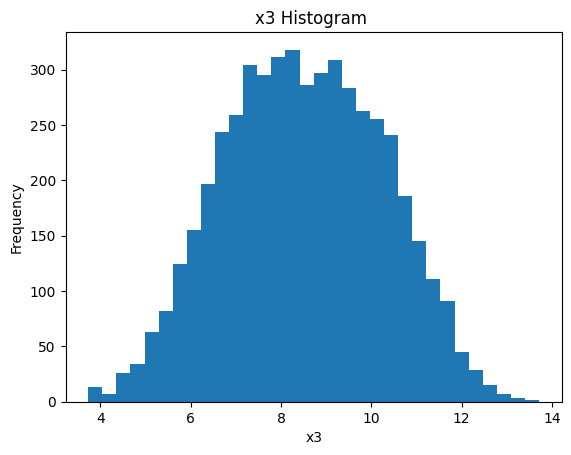

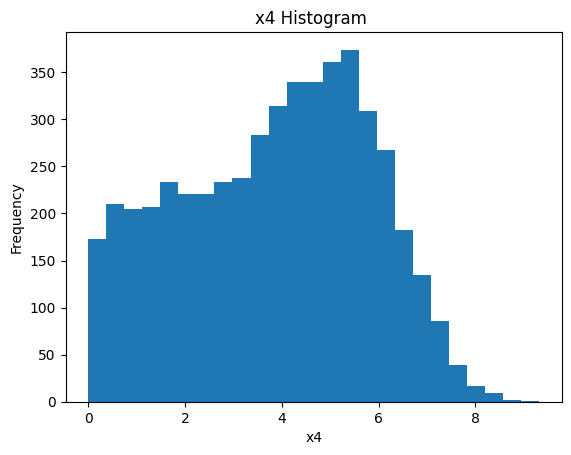

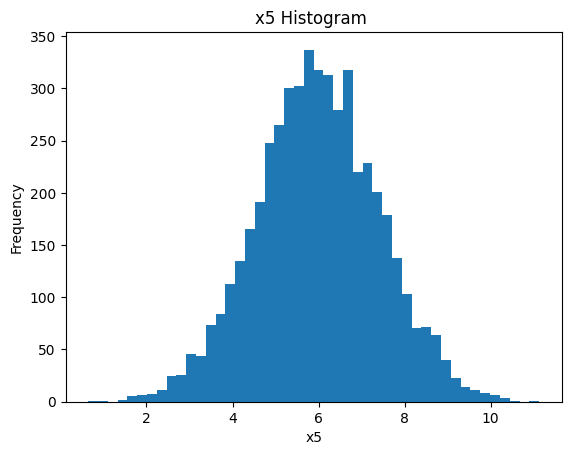

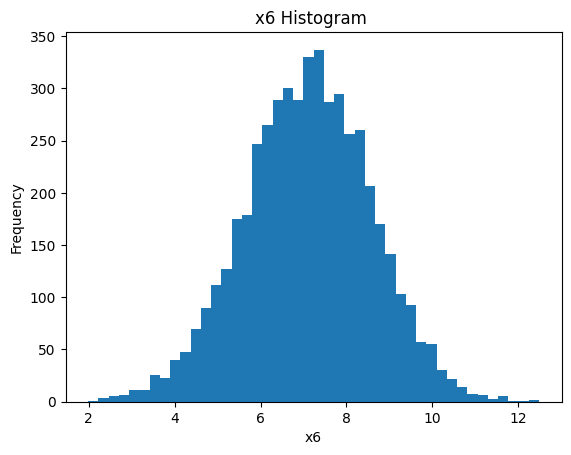

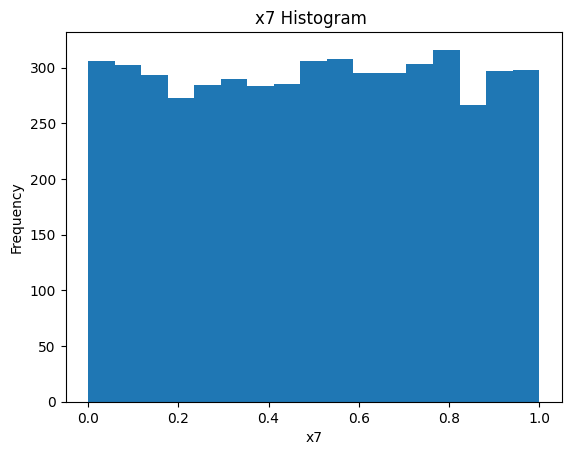

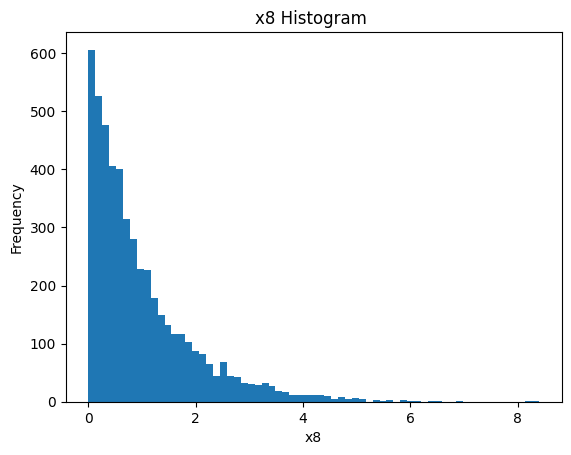

In [6]:
from matplotlib import pyplot as plt

for idx, col in enumerate(dados.columns[:-1]):
    plt.hist(dados[col], bins=determina_bins(dados[col]))
    plt.title(f'{col} Histogram ')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

#  2. Modificações nos dados

## 2.1 Converte os dados para distribuição

In [7]:
import numpy as np
import bisect

def converte_bins(x):
    '''
    Converte a coluna x em bins discretos.
    Parâmetros:
    x: array-like, coluna a ser convertida.
    bins: int, número de bins.
    Retorna:
    array-like, coluna
    '''
    edge = np.linspace(x.min(), x.max(), determina_bins(x)+1)

    x_bins = []
    for xi in x:
      x_bins.append(bisect.bisect_left(edge, xi))
    return x_bins

In [8]:
dados_bins = pd.DataFrame()
for col in dados.columns[:-1]:
    dados_bins['b'+col] = converte_bins(dados[col])
dados_bins

,bx1,bx2,bx3,bx4,bx5,bx6,bx7,bx8
0,27,21,9,0,24,14,10,5
1,22,18,6,1,23,8,1,23
2,30,23,10,1,32,20,7,8
3,21,17,6,1,21,11,4,13
4,30,23,10,1,23,15,10,5
...,...,...,...,...,...,...,...,...
4995,35,23,29,2,32,27,17,1
4996,25,16,24,2,22,23,15,2
4997,19,12,21,2,23,11,16,1
4998,16,10,19,1,17,14,16,1


# 2.2 Transformações

In [9]:

!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.1 MB/s eta 0:00:00


Primeiramente determina-se o valor de alpha por meio do Optuna e depois aplica a transformação x' = x**alpha.



In [10]:
from scipy.stats import shapiro
import optuna as opt

opt.logging.set_verbosity(opt.logging.CRITICAL)

def objective(trial, col_idx):
    col = dados.columns[col_idx]
    alpha = trial.suggest_float('alpha', -1.0, 1.0)
    coluna_modificada = dados[col]
    try:
        dados_transf = coluna_modificada**alpha
        if np.any(np.isnan(dados_transf)) or np.any(np.isinf(dados_transf)):
            return -np.inf  # penaliza soluções inválidas
        stat, p = shapiro(dados_transf)
        return stat
    except Exception:
        return -np.inf

print(f'  Coluna  | Alfa')
print(f'----------|-------------')
parametro_alpha_transformacao = []
for idx in range(len(dados.columns)-1):
    study = opt.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, idx), n_trials=100, show_progress_bar=False)
    print(f'{dados.columns[idx].center(9)} | {study.best_params["alpha"]:.3f}')
    parametro_alpha_transformacao.append(np.float64(study.best_params["alpha"]))

  Coluna  | Alfa
----------|-------------
    x1    | 1.000
    x2    | 1.000
    x3    | 0.938
    x4    | 1.000
    x5    | 1.000
    x6    | 0.999
    x7    | 0.831
    x8    | 0.270


In [11]:
dados_transformados = pd.DataFrame()
for idx, col in enumerate(colunas):
    dados_transformados['t'+col] = np.power(dados[col], parametro_alpha_transformacao[idx])

In [12]:
dados_transformados.isna().sum()

,0
tx1,0
tx2,0
tx3,0
tx4,0
tx5,0
tx6,0
tx7,0
tx8,0


Mostrar os histogramas originais e dos dados transformados

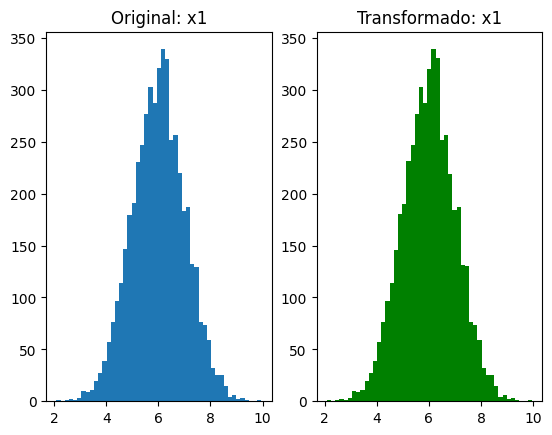

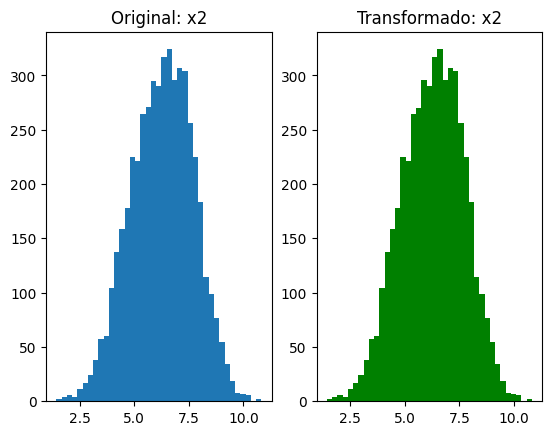

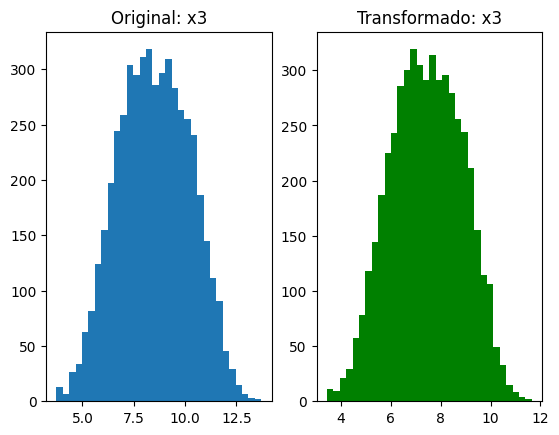

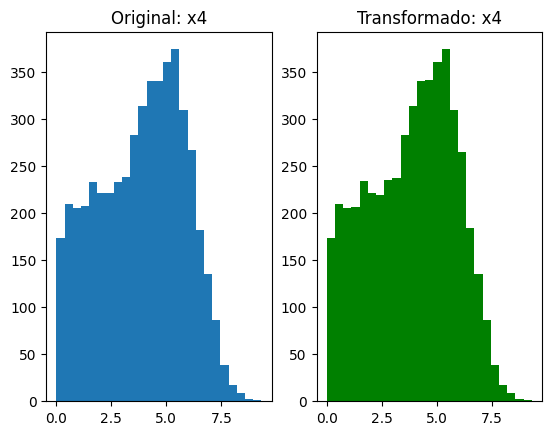

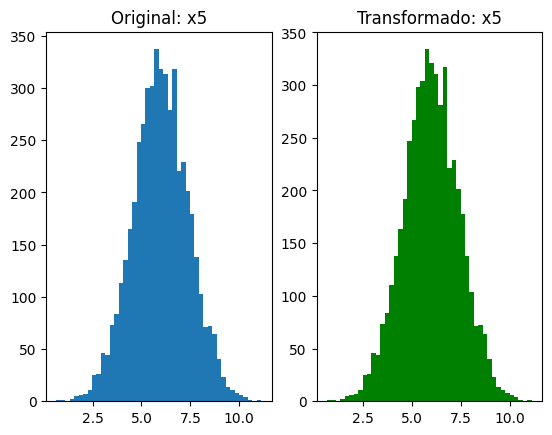

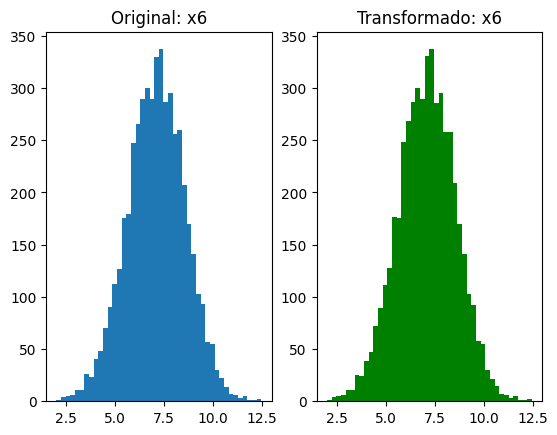

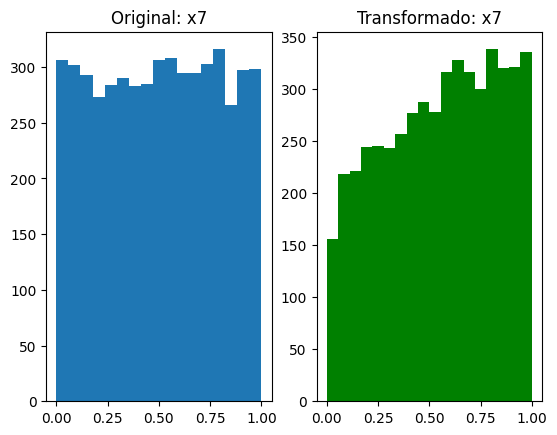

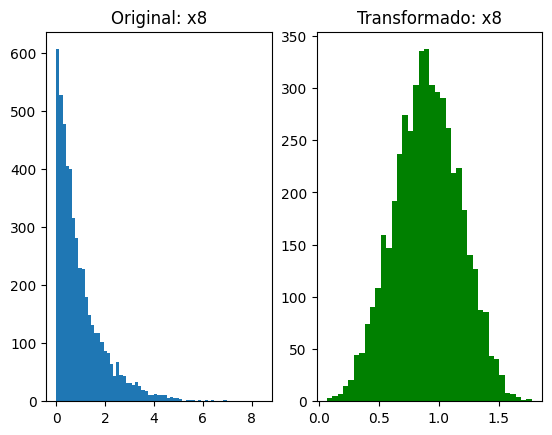

In [13]:
# Exemplo: mostrar histogramas antes e depois da transformação para cada coluna
import matplotlib.pyplot as plt

for idx in range(len(dados.columns)-1):
    col = dados.columns[idx]

    plt.subplot(1, 2, 1)
    plt.hist(dados[col], bins=determina_bins(dados[col]))
    plt.title(f'Original: {col}')
    plt.subplot(1, 2, 2)
    plt.hist(dados_transformados['t'+col], bins=determina_bins(dados_transformados['t'+col]), color= 'g')
    plt.title(f'Transformado: {col}')
    plt.show()

## 2.3 Cria interações entre os dados

Aqui serão criadas interações entre os dados originais (apenas entre eles), entre os dados transformados em 2.2 (apenas entre eles) e entre os dados transformado em bins em 2.1 (apenas entre eles).

As interações a serem feitas são de multiplicação e potencia (até a 3), utilizando PolynomialFeatures do Sklearn.

In [14]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False)
dados_inter = pd.DataFrame(poly.fit_transform(dados[dados.columns[:-1]]))
dados_inter.columns = poly.get_feature_names_out()

dados_inter

,x1,x2,x3,x4,x5,x6,x7,x8,x1^2,x1 x2,...,x6^3,x6^2 x7,x6^2 x8,x6 x7^2,x6 x7 x8,x6 x8^2,x7^3,x7^2 x8,x7 x8^2,x8^3
0,6.260271,6.260271,6.260271,0.000000,5.948349,5.184780,0.532488,0.630195,39.190988,39.190988,...,139.376974,14.314305,16.940881,1.470109,1.739864,2.059117,0.150983,0.178688,0.211476,0.250280
1,5.571113,5.574113,5.572113,0.013928,5.839541,3.864820,0.053764,2.923160,31.037301,31.054015,...,57.728164,0.803057,43.662755,0.011171,0.607393,33.024368,0.000155,0.008449,0.459402,24.978014
2,6.815071,6.821071,6.817071,0.034075,7.772885,6.700514,0.383310,0.958911,46.445188,46.486078,...,300.832211,17.209429,43.052119,0.984484,2.462843,6.161192,0.056318,0.140890,0.352458,0.881729
3,5.341686,5.350686,5.344686,0.040062,5.207846,4.376286,0.187014,1.676573,28.533612,28.581687,...,83.814118,3.581665,32.109531,0.153057,1.372151,12.301293,0.006541,0.058637,0.525676,4.712675
4,6.844099,6.856099,6.848099,0.068440,5.748673,5.479708,0.573499,0.555999,46.841692,46.923820,...,164.540273,17.220578,16.695078,1.802284,1.747286,1.693966,0.188625,0.182869,0.177288,0.171878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,7.674359,6.870954,12.669359,0.604654,7.799037,8.375024,0.950061,0.051229,58.895791,52.730172,...,587.432741,66.638273,3.593237,7.559435,0.407616,0.021979,0.857541,0.046240,0.002493,0.000134
4996,6.051771,5.245834,11.047771,0.461728,5.628362,7.243200,0.841650,0.172392,36.623928,31.746584,...,380.006832,44.156254,9.044342,5.130894,1.050940,0.215260,0.596203,0.122118,0.025013,0.005123
4997,5.076293,4.267828,10.073293,0.374648,5.773208,4.502632,0.887057,0.119846,25.768751,21.664743,...,91.284981,17.983931,2.429712,3.542990,0.478674,0.064671,0.698000,0.094303,0.012741,0.001721
4998,4.647603,3.836612,9.645603,0.331421,4.326846,5.158021,0.932182,0.070227,21.600214,17.831051,...,137.230056,24.800862,1.868414,4.482128,0.337669,0.025439,0.810031,0.061025,0.004597,0.000346


In [15]:
poly = PolynomialFeatures(degree=3, include_bias=False)
dados_transformados_inter = pd.DataFrame(poly.fit_transform(dados_transformados))
dados_transformados_inter.columns = poly.get_feature_names_out()

dados_transformados_inter

,tx1,tx2,tx3,tx4,tx5,tx6,tx7,tx8,tx1^2,tx1 tx2,...,tx6^3,tx6^2 tx7,tx6^2 tx8,tx6 tx7^2,tx6 tx7 tx8,tx6 tx8^2,tx7^3,tx7^2 tx8,tx7 tx8^2,tx8^3
0,6.259447,6.259932,5.586276,0.000000,5.945360,5.177753,0.592404,0.882834,39.180672,39.183709,...,138.811040,15.881826,23.668008,1.817092,2.707934,4.035519,0.207899,0.309824,0.461717,0.688077
1,5.570426,5.573831,5.008296,0.013947,5.836638,3.860516,0.088163,1.335771,31.029651,31.048613,...,57.535540,1.313950,19.907784,0.030007,0.454638,6.888262,0.000685,0.010383,0.157309,2.383397
2,6.814132,6.820684,6.051026,0.034113,7.768394,6.690019,0.450830,0.988740,46.432398,46.477044,...,299.420794,20.177523,44.252383,1.359733,2.982102,6.540205,0.091630,0.200959,0.440735,0.966598
3,5.341044,5.350421,4.816329,0.040105,5.205425,4.370966,0.248354,1.149664,28.526750,28.576836,...,83.508788,4.744897,21.964721,0.269601,1.248016,5.777224,0.015318,0.070911,0.328257,1.519542
4,6.843154,6.855710,6.076854,0.068500,5.745840,5.472032,0.630070,0.853486,46.828763,46.914679,...,163.849753,18.866274,25.556030,2.172333,2.942617,3.986034,0.250131,0.338824,0.458967,0.621711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,7.673237,6.870564,10.821076,0.604754,7.794524,8.360368,0.958332,0.448438,58.878564,52.719462,...,584.354320,66.983353,31.343881,7.678166,3.592886,1.681238,0.880133,0.411845,0.192717,0.090179
4996,6.050989,5.245577,9.516655,0.461845,5.625622,7.231390,0.866561,0.622212,36.614464,31.740929,...,378.151134,45.315067,32.537318,5.430250,3.899052,2.799614,0.650724,0.467236,0.335487,0.240888
4997,5.075701,4.267645,8.727135,0.374768,5.770356,4.497052,0.905229,0.564057,25.762743,21.661291,...,90.946036,18.306871,11.407196,3.685059,2.296198,1.430784,0.741779,0.462210,0.288008,0.179461
4998,4.647090,3.836460,8.379146,0.331541,4.325061,5.151052,0.943324,0.488288,21.595450,17.828377,...,136.674589,25.029544,12.955906,4.583720,2.372646,1.228140,0.839428,0.434508,0.224912,0.116420


Também serão feitas as interações de soma entre 2 atributos e de max(a,b) para os mesmos conjuntos de dados, entre eles, como descrito acima. Este já são adicionados ao dataframe das interações polinomiais.

In [16]:
len_dados = len(dados.columns)-1
for idx1 in range(len_dados):
  for idx2 in range(idx1+1, len_dados):
    col1 = dados.columns[idx1]
    col2 = dados.columns[idx2]
    dados_inter[f'{col1}+{col2}'] = dados[col1] + dados[col2]
    dados_inter[f'max({col1},{col2})'] = np.maximum(dados[col1], dados[col2])
dados_inter

,x1,x2,x3,x4,x5,x6,x7,x8,x1^2,x1 x2,...,x5+x7,"max(x5,x7)",x5+x8,"max(x5,x8)",x6+x7,"max(x6,x7)",x6+x8,"max(x6,x8)",x7+x8,"max(x7,x8)"
0,6.260271,6.260271,6.260271,0.000000,5.948349,5.184780,0.532488,0.630195,39.190988,39.190988,...,6.480836,5.948349,6.578544,5.948349,5.717268,5.184780,5.814976,5.184780,1.162683,0.630195
1,5.571113,5.574113,5.572113,0.013928,5.839541,3.864820,0.053764,2.923160,31.037301,31.054015,...,5.893304,5.839541,8.762701,5.839541,3.918583,3.864820,6.787980,3.864820,2.976924,2.923160
2,6.815071,6.821071,6.817071,0.034075,7.772885,6.700514,0.383310,0.958911,46.445188,46.486078,...,8.156195,7.772885,8.731796,7.772885,7.083824,6.700514,7.659425,6.700514,1.342221,0.958911
3,5.341686,5.350686,5.344686,0.040062,5.207846,4.376286,0.187014,1.676573,28.533612,28.581687,...,5.394860,5.207846,6.884419,5.207846,4.563300,4.376286,6.052859,4.376286,1.863587,1.676573
4,6.844099,6.856099,6.848099,0.068440,5.748673,5.479708,0.573499,0.555999,46.841692,46.923820,...,6.322172,5.748673,6.304671,5.748673,6.053207,5.479708,6.035706,5.479708,1.129498,0.573499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,7.674359,6.870954,12.669359,0.604654,7.799037,8.375024,0.950061,0.051229,58.895791,52.730172,...,8.749099,7.799037,7.850266,7.799037,9.325085,8.375024,8.426253,8.375024,1.001290,0.950061
4996,6.051771,5.245834,11.047771,0.461728,5.628362,7.243200,0.841650,0.172392,36.623928,31.746584,...,6.470012,5.628362,5.800754,5.628362,8.084849,7.243200,7.415591,7.243200,1.014041,0.841650
4997,5.076293,4.267828,10.073293,0.374648,5.773208,4.502632,0.887057,0.119846,25.768751,21.664743,...,6.660265,5.773208,5.893054,5.773208,5.389689,4.502632,4.622477,4.502632,1.006903,0.887057
4998,4.647603,3.836612,9.645603,0.331421,4.326846,5.158021,0.932182,0.070227,21.600214,17.831051,...,5.259028,4.326846,4.397074,4.326846,6.090202,5.158021,5.228248,5.158021,1.002409,0.932182


In [17]:
len_dados_transformados = len(dados_transformados.columns)
for idx1 in range(len_dados_transformados):
  for idx2 in range(idx1+1, len_dados_transformados):
    col1 = dados_transformados.columns[idx1]
    col2 = dados_transformados.columns[idx2]
    dados_transformados_inter[f'{col1}+{col2}'] = dados_transformados[col1] + dados_transformados[col2]
    dados_transformados_inter[f'max({col1},{col2})'] = np.maximum(dados_transformados[col1], dados_transformados[col2])
dados_transformados_inter

,tx1,tx2,tx3,tx4,tx5,tx6,tx7,tx8,tx1^2,tx1 tx2,...,tx5+tx7,"max(tx5,tx7)",tx5+tx8,"max(tx5,tx8)",tx6+tx7,"max(tx6,tx7)",tx6+tx8,"max(tx6,tx8)",tx7+tx8,"max(tx7,tx8)"
0,6.259447,6.259932,5.586276,0.000000,5.945360,5.177753,0.592404,0.882834,39.180672,39.183709,...,6.537764,5.945360,6.828194,5.945360,5.770157,5.177753,6.060587,5.177753,1.475238,0.882834
1,5.570426,5.573831,5.008296,0.013947,5.836638,3.860516,0.088163,1.335771,31.029651,31.048613,...,5.924801,5.836638,7.172409,5.836638,3.948680,3.860516,5.196288,3.860516,1.423935,1.335771
2,6.814132,6.820684,6.051026,0.034113,7.768394,6.690019,0.450830,0.988740,46.432398,46.477044,...,8.219224,7.768394,8.757134,7.768394,7.140849,6.690019,7.678758,6.690019,1.439570,0.988740
3,5.341044,5.350421,4.816329,0.040105,5.205425,4.370966,0.248354,1.149664,28.526750,28.576836,...,5.453779,5.205425,6.355089,5.205425,4.619320,4.370966,5.520630,4.370966,1.398018,1.149664
4,6.843154,6.855710,6.076854,0.068500,5.745840,5.472032,0.630070,0.853486,46.828763,46.914679,...,6.375910,5.745840,6.599326,5.745840,6.102102,5.472032,6.325517,5.472032,1.483556,0.853486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,7.673237,6.870564,10.821076,0.604754,7.794524,8.360368,0.958332,0.448438,58.878564,52.719462,...,8.752856,7.794524,8.242962,7.794524,9.318701,8.360368,8.808806,8.360368,1.406770,0.958332
4996,6.050989,5.245577,9.516655,0.461845,5.625622,7.231390,0.866561,0.622212,36.614464,31.740929,...,6.492183,5.625622,6.247834,5.625622,8.097951,7.231390,7.853602,7.231390,1.488772,0.866561
4997,5.075701,4.267645,8.727135,0.374768,5.770356,4.497052,0.905229,0.564057,25.762743,21.661291,...,6.675585,5.770356,6.334413,5.770356,5.402281,4.497052,5.061109,4.497052,1.469286,0.905229
4998,4.647090,3.836460,8.379146,0.331541,4.325061,5.151052,0.943324,0.488288,21.595450,17.828377,...,5.268385,4.325061,4.813349,4.325061,6.094376,5.151052,5.639340,5.151052,1.431612,0.943324


# 3. Cálculo das correlações entre os dados de entrada e a saída



## 3.1 Cálculo da *Mutual Information*

Calculo da *Mutual Information* por meio do hitograma. A forma de definir o número de bins pode ser escolhido entre os métodos Classico, Struges, Scoot e Freedman-Diaconis.

In [18]:
def calc_mi(x, y, bins_rule='classic'):
    '''Calcula a Mutual Information entre duas variáveis x e y usando histogramas.
    Parâmetros:
    x: array-like, primeira variável.
    y: array-like, segunda variável.
    bins_rule: str, regra para determinar o número de bins. Opções: 'classic', 'sturges', 'scott', 'fd'.
    Retorna:
    mi: float, valor da Mutual Information.
    '''

    bins_x = determina_bins(x, bins_rule)
    bins_y = determina_bins(y, bins_rule)

    hist2d, x_edges, y_edges = np.histogram2d(x, y, bins=[bins_x, bins_y])

    hist2d_norm = hist2d / np.sum(hist2d)

    hist_x = np.sum(hist2d_norm, axis=1)
    hist_y = np.sum(hist2d_norm, axis=0)

    entropia_x = -sum(hist_x[hist_x > 0] * np.log(hist_x[hist_x > 0]))
    entropia_y = -sum(hist_y[hist_y > 0] * np.log(hist_y[hist_y > 0]))

    entropia_conjunta = -sum(hist2d_norm[hist2d_norm > 0] * np.log(hist2d_norm[hist2d_norm > 0]))

    mi = entropia_x + entropia_y - entropia_conjunta

    return mi

**Dúvida:** Na minha cabeça faz mais sentido colocar os os métodos de determinação da bin como entrada, pode ser assim?

Testes da Mutual Information utilizando diferentes formas de calcular os bins, apenas para os dados originais.

In [19]:
bins_rule = ['classic', 'sturges', 'scott', 'fd']

print(f'  Teste do Mutual Information com os dados originais\n')
print(f'  Dado   | {bins_rule[0]} | {bins_rule[1]} |  {bins_rule[2]}  |  {bins_rule[3]}')
print(f'---------|---------|---------|---------|--------')
for idx, col in enumerate(dados.columns[:-1]):
    bins_list = []
    for br in bins_rule:
        bins_list.append(calc_mi(dados[col], dados[y_col], bins_rule=br))
    print(f'{col.center(9)}|  {bins_list[0]:.3f}  |  {bins_list[1]:.3f}  |  {bins_list[2]:.3f}  |  {bins_list[3]:.3f}')


  Teste do Mutual Information com os dados originais

  Dado   | classic | sturges |  scott  |  fd
---------|---------|---------|---------|--------
    x1   |  0.867  |  0.671  |  0.761  |  0.793
    x2   |  0.686  |  0.439  |  0.544  |  0.569
    x3   |  0.611  |  0.363  |  0.437  |  0.462
    x4   |  0.555  |  0.294  |  0.352  |  0.371
    x5   |  0.598  |  0.382  |  0.453  |  0.490
    x6   |  0.579  |  0.361  |  0.430  |  0.466
    x7   |  0.378  |  0.023  |  0.054  |  0.076
    x8   |  0.223  |  0.021  |  0.086  |  0.153


Mutual Information, usando Freedman–Diaconis, aplicada aos dados originais, aos dados em bins e aos dados transformados, todos com as suas interações.

In [20]:
print(f'    Dado    | Original | Transformado ')
print(f'------------|----------|--------------')

col_transf = dados_transformados_inter.columns

mi_dados_list = []
mi_transform_list = []

for idx, col in enumerate(dados_inter.columns):
    mi_dados = calc_mi(dados_inter[col], dados['y'], bins_rule='fd')
    mi_transform = calc_mi(dados_transformados_inter[col_transf[idx]], dados['y'], bins_rule='fd')

    mi_dados_list.append(mi_dados)
    mi_transform_list.append(mi_transform)

    print(f'{col.center(12)}|   {mi_dados:.3f}  |     {mi_transform:.3f}    ')

    Dado    | Original | Transformado 
------------|----------|--------------
     x1     |   0.793  |     0.794    
     x2     |   0.569  |     0.569    
     x3     |   0.462  |     0.465    
     x4     |   0.371  |     0.371    
     x5     |   0.490  |     0.490    
     x6     |   0.466  |     0.465    
     x7     |   0.076  |     0.079    
     x8     |   0.153  |     0.138    
    x1^2    |   0.792  |     0.792    
   x1 x2    |   0.709  |     0.709    
   x1 x3    |   0.801  |     0.817    
   x1 x4    |   0.529  |     0.529    
   x1 x5    |   0.747  |     0.746    
   x1 x6    |   0.754  |     0.754    
   x1 x7    |   0.143  |     0.154    
   x1 x8    |   0.177  |     0.281    
    x2^2    |   0.567  |     0.567    
   x2 x3    |   0.720  |     0.719    
   x2 x4    |   0.470  |     0.470    
   x2 x5    |   0.690  |     0.689    
   x2 x6    |   0.753  |     0.752    
   x2 x7    |   0.134  |     0.143    
   x2 x8    |   0.180  |     0.271    
    x3^2    |   0.464  | 

## 3.2 Hilbert-Schmidt Independence Criterion (HSIC)

In [21]:
from sklearn.metrics.pairwise import rbf_kernel

def calc_hsic(x, y, sigma_x = None, sigma_y = None):

    x = np.asarray(x)
    y = np.asarray(y)

    len_x = len(x)

    H = np.eye(len_x) - np.ones((len_x, len_x))/len_x

    if sigma_x is None:
        sigma_x = np.median(np.abs(x[:, None] - x[None, :]))

    if sigma_y is None:
        sigma_y = np.median(np.abs(y[:, None] - y[None, :]))

    K = rbf_kernel(x.reshape(-1, 1), gamma=1/(2*sigma_x**2))
    L = rbf_kernel(y.reshape(-1, 1), gamma=1/(2*sigma_y**2))

    return np.trace(H @ K @ H @ L) / (len_x - 1)**2

**Dúvida:** Na minha cabeça faz mais sentido calcular o sigma para os dados inseridos, pode ser assim?

HSIC aplicada aos dados originais, aos dados em bins e aos dados transformados.

In [22]:
col_transf = dados_transformados_inter.columns


hsic_dados_list = []
hsic_transform_list = []


print(f'    Dado    | Original | Transformado ')
print(f'------------|----------|--------------')
for idx, col in enumerate(dados_inter.columns):
  hsic_dados = calc_hsic(dados_inter[col], dados['y'])
  hsic_transform = calc_hsic(dados_transformados_inter[col_transf[idx]], dados['y'])

  hsic_dados_list.append(hsic_dados)
  hsic_transform_list.append(hsic_transform)

  print(f'{col.ljust(12)}|  {hsic_dados:.5f} |    {hsic_transform:.5f}   ')


    Dado    | Original | Transformado 
------------|----------|--------------
x1          |  0.04797 |    0.04797   
x2          |  0.02400 |    0.02400   
x3          |  0.02541 |    0.02538   
x4          |  0.01783 |    0.01782   
x5          |  0.02936 |    0.02936   
x6          |  0.02714 |    0.02714   
x7          |  0.00061 |    0.00063   
x8          |  0.00052 |    0.00053   
x1^2        |  0.04767 |    0.04767   
x1 x2       |  0.04167 |    0.04167   
x1 x3       |  0.04889 |    0.04958   
x1 x4       |  0.03104 |    0.03104   
x1 x5       |  0.04559 |    0.04559   
x1 x6       |  0.04564 |    0.04564   
x1 x7       |  0.00195 |    0.00262   
x1 x8       |  0.00238 |    0.01280   
x2^2        |  0.02418 |    0.02418   
x2 x3       |  0.04401 |    0.04409   
x2 x4       |  0.02945 |    0.02945   
x2 x5       |  0.04122 |    0.04122   
x2 x6       |  0.04528 |    0.04528   
x2 x7       |  0.00183 |    0.00240   
x2 x8       |  0.00263 |    0.01191   
x3^2        |  0.02557 | 

### 3.3. Definição dos mais influentes

Lista os atributos e suas interações com maior corelação com a saída (MI e HSIC separadamente) para cada "conjunto de dados"

In [23]:
n_maior = 20
col = dados_inter.columns

idx_dados_hsic = np.argpartition(hsic_dados_list, -n_maior)[-n_maior:]
idx_dados_transform_hsic = np.argpartition(hsic_transform_list, -n_maior)[-n_maior:]

idx_dados_mi = np.argpartition(mi_dados_list, -n_maior)[-n_maior:]
idx_dados_transform_mi = np.argpartition(mi_transform_list, -n_maior)[-n_maior:]

print(f"{n_maior} maiores valores para os Dados Originais:")
print(f'    Dado    |   HSIC   |    Dado     |    MI     ')
print(f'------------|----------|-------------|----------')
for idx in range(n_maior):
    print(f'{col[idx_dados_hsic[idx]].center(12)}|  {hsic_dados_list[idx_dados_hsic[idx]]:.5f} '
          f'| {col[idx_dados_mi[idx]].center(12)}|  {mi_dados_list[idx_dados_mi[idx]]:.5f} ')

print('--------------------------------------------------')
print(f"{n_maior} maiores valores para os Dados Transform:")
print(f'    Dado    |   HSIC   |    Dado     |    MI     ')
print(f'------------|----------|-------------|----------')
for idx in range(n_maior):
    print(f'{col[idx_dados_transform_hsic[idx]].center(12)}|  {hsic_transform_list[idx_dados_transform_hsic[idx]]:.5f} '
          f'| {col[idx_dados_transform_mi[idx]].center(12)}|  {mi_transform_list[idx_dados_transform_mi[idx]]:.5f} ')


20 maiores valores para os Dados Originais:
    Dado    |   HSIC   |    Dado     |    MI     
------------|----------|-------------|----------
    x1^3    |  0.04658 |     x1^2    |  0.79171 
    x1^2    |  0.04767 |  max(x1,x4) |  0.79349 
  x1 x2 x5  |  0.04793 |  max(x1,x7) |  0.79349 
 max(x1,x7) |  0.04797 |      x1     |  0.79349 
 max(x1,x4) |  0.04797 |     x1^3    |  0.79386 
     x1     |  0.04797 |  max(x1,x8) |  0.79603 
 max(x1,x8) |  0.04804 |    x1 x3    |  0.80058 
  x1^2 x5   |  0.04864 |   x1^2 x5   |  0.82634 
  x1^2 x6   |  0.04881 |   x1 x2 x5  |  0.82975 
   x1 x3    |  0.04889 |   x1^2 x6   |  0.83923 
  x1 x5 x6  |  0.05031 |   x1 x5 x6  |  0.86493 
  x1 x2 x6  |  0.05097 |   x1 x3 x6  |  0.87202 
  x1 x3 x6  |  0.05139 |   x1 x2 x6  |  0.88276 
  x3 x5 x6  |  0.05228 |   x3 x5 x6  |  0.89004 
  x2 x5 x6  |  0.05263 |   x1 x2 x3  |  0.91224 
  x1^2 x3   |  0.05277 |   x1^2 x3   |  0.92375 
  x1 x2 x3  |  0.05286 |   x2 x5 x6  |  0.92713 
  x2 x3 x6  |  0.05378 |

Encontra os atributos e suas interações com maior corelação com a saída no MI **e** no HSIC para cada "conjunto de dados"

In [24]:
idx_dados = list(set(idx_dados_hsic) & set(idx_dados_mi))
idx_dados_transform = list(set(idx_dados_transform_hsic) & set(idx_dados_transform_mi))

print(f"Atributos com maiores valores de HSIC e MI para os Dados Originais:")
print(f'    Dado    |   HSIC   |    MI    | Contagem')
print(f'------------|----------|----------|----------')
for cont, idx in enumerate(range(len(idx_dados))):
    print(f'{col[idx_dados[idx]].center(12)}|  {hsic_dados_list[idx_dados[idx]]:.5f} '
          f'|  {mi_dados_list[idx_dados[idx]]:.5f}  | {cont + 1}')

print('--------------------------------------------------')
print(f"Atributos com maiores valores de HSIC e MI para os Dados Transform:")
print(f'    Dado    |   HSIC   |    MI    | Contagem')
print(f'------------|----------|----------|----------')
for cont, idx in enumerate(range(len(idx_dados_transform))):
    print(f'{col[idx_dados_transform[idx]].center(12)}|  {hsic_transform_list[idx_dados_transform[idx]]:.5f} '
          f'|  {mi_transform_list[idx_dados_transform[idx]]:.5f}  | {cont + 1}')



Atributos com maiores valores de HSIC e MI para os Dados Originais:
    Dado    |   HSIC   |    MI    | Contagem
------------|----------|----------|----------
     x1     |  0.04797 |  0.79349  | 1
    x1^2    |  0.04767 |  0.79171  | 2
   x1 x3    |  0.04889 |  0.80058  | 3
 max(x1,x4) |  0.04797 |  0.79349  | 4
    x1^3    |  0.04658 |  0.79386  | 5
  x1^2 x3   |  0.05277 |  0.92375  | 6
 max(x1,x7) |  0.04797 |  0.79349  | 7
  x1^2 x5   |  0.04864 |  0.82634  | 8
 max(x1,x8) |  0.04804 |  0.79603  | 9
  x1^2 x6   |  0.04881 |  0.83923  | 10
  x1 x2 x3  |  0.05286 |  0.91224  | 11
  x1 x2 x5  |  0.04793 |  0.82975  | 12
  x1 x2 x6  |  0.05097 |  0.88276  | 13
  x1 x3 x5  |  0.05396 |  0.94025  | 14
  x1 x3 x6  |  0.05139 |  0.87202  | 15
  x1 x5 x6  |  0.05031 |  0.86493  | 16
  x2 x3 x5  |  0.05419 |  0.94687  | 17
  x2 x3 x6  |  0.05378 |  0.94909  | 18
  x2 x5 x6  |  0.05263 |  0.92713  | 19
  x3 x5 x6  |  0.05228 |  0.89004  | 20
--------------------------------------------------

# 4. Avaliação com xgBoost + SHAP

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
import xgboost

import shap

## 4.1. Avaliação dos Atibutos Transformados e Interados

Primeiro cria uma função para avaliação dos atributos por meio do SHAP.

Para esta avaliação, utiliza-se a explicabilidade do SHAP sobre os próprios dados de treinamento, uma vez que se deseja saber a importancia dos atributos para uso em um treinamento futuro e não para um dado atual.

In [26]:
def avaliar_atributos(X, y, f_corte=0.10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBRegressor()
    model.fit(X_train, y_train)

    shap.initjs()
    explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
    explanation = explainer(X_train)

    shap.plots.bar(explanation, max_display=20)
    out = pd.DataFrame()
    out['feature'] = explanation.feature_names
    out['importance'] = abs(explanation.values).mean(axis=0)
    out = out.sort_values(by='importance', ascending=False).reset_index(drop=True)
    out = out[out['importance'] > out['importance'][0]*f_corte]
    print(out)
    return out



### 4.1.1. Avaliação dos Atributos **Originais** Interados

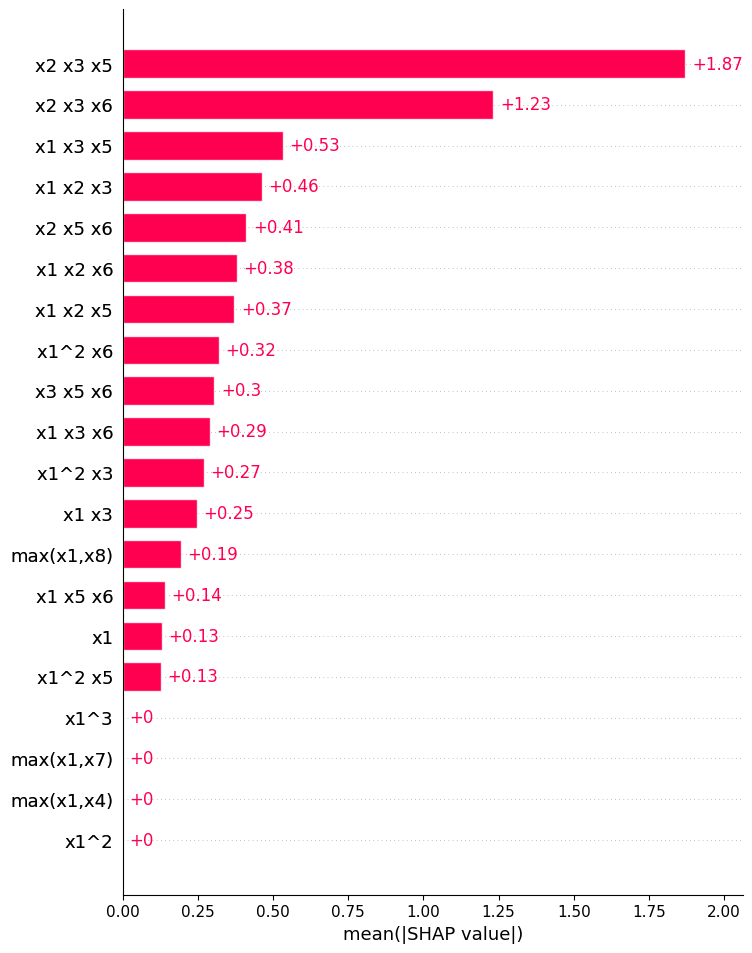

       feature  importance
0     x2 x3 x5    1.870769
1     x2 x3 x6    1.232429
2     x1 x3 x5    0.533119
3     x1 x2 x3    0.461448
4     x2 x5 x6    0.410275
5     x1 x2 x6    0.379972
6     x1 x2 x5    0.370267
7      x1^2 x6    0.319459
8     x3 x5 x6    0.304342
9     x1 x3 x6    0.289131
10     x1^2 x3    0.269039
11       x1 x3    0.246538
12  max(x1,x8)    0.192585


In [27]:
f_dados_shap = avaliar_atributos(dados_inter[dados_inter.columns[idx_dados]], dados['y'])


### 4.1.2. Avaliação dos Atributos **Transformados** Interados

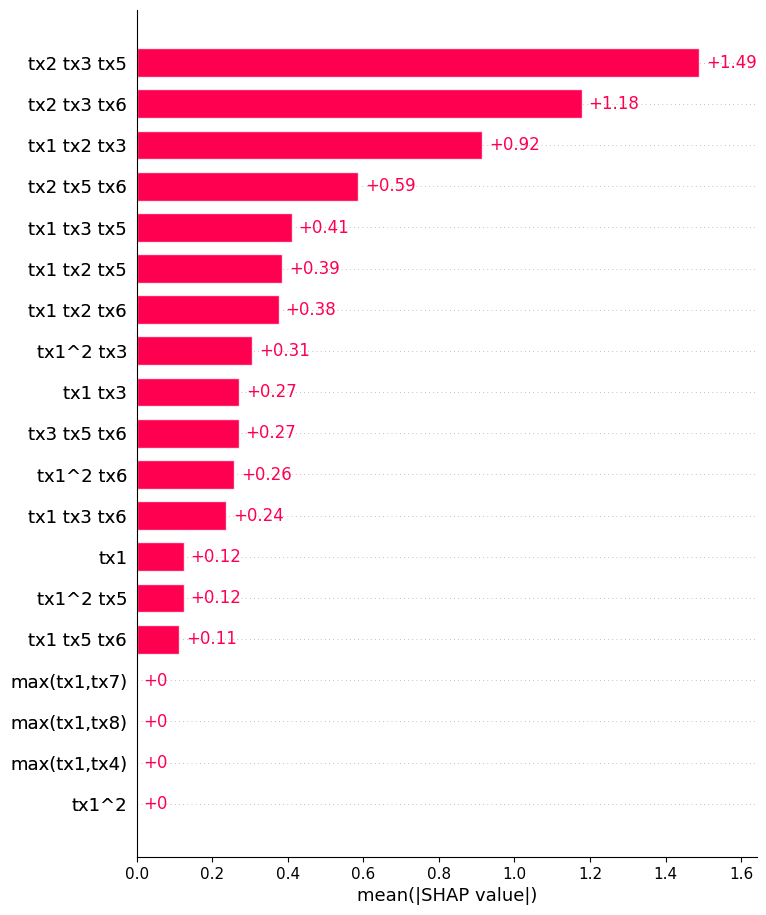

        feature  importance
0   tx2 tx3 tx5    1.489222
1   tx2 tx3 tx6    1.178506
2   tx1 tx2 tx3    0.915117
3   tx2 tx5 tx6    0.586873
4   tx1 tx3 tx5    0.410666
5   tx1 tx2 tx5    0.385177
6   tx1 tx2 tx6    0.375168
7     tx1^2 tx3    0.305684
8       tx1 tx3    0.270936
9   tx3 tx5 tx6    0.270331
10    tx1^2 tx6    0.258078
11  tx1 tx3 tx6    0.237306


In [28]:
f_dados_transformados_shap = avaliar_atributos(dados_transformados_inter[dados_transformados_inter.columns[idx_dados_transform]], dados['y'])

## 4.2. Teste dos Atributos

Testa os dados originais, separados por bins e transformados com todos os atributos. Em seguida testa os mesmos, mas apenas com os melhores atributos definidos na list *col_top*.

In [29]:
def evaluate_model_xgBoost(X, y, id):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = XGBRegressor()
  model.fit(X_train, y_train)

  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)

  y_pred = model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  print(f'{id.ljust(20)}|  {mse_train:.3f}  |  {mse:.3f}')

In [30]:
print(f'        Dado        |  Train  | Test ')
print(f'--------------------|---------|-------')
evaluate_model_xgBoost(dados[dados.columns[:-1]], dados['y'], 'Atributos Originais')
evaluate_model_xgBoost(dados_bins, dados['y'], 'Atributos em Bins')
evaluate_model_xgBoost(dados_transformados, dados['y'], 'Atributos Transf.')
print(f'--------------------|---------|-------')
evaluate_model_xgBoost(dados_inter[dados_inter.columns[:8].to_list() + f_dados_shap['feature'].to_list()], dados['y'], 'At. Originais + SHAP')
evaluate_model_xgBoost(dados_transformados_inter[dados_transformados_inter.columns[:8].to_list() + f_dados_transformados_shap['feature'].to_list()], dados['y'], 'At. Transf. + SHAP')
evaluate_model_xgBoost(pd.concat([dados[dados.columns[:-1]], dados_transformados_inter[f_dados_transformados_shap['feature'].to_list()]], axis=1), dados['y'], 'At Orig + Tran SHAP')

        Dado        |  Train  | Test 
--------------------|---------|-------
Atributos Originais |  0.032  |  0.520
Atributos em Bins   |  0.053  |  0.451
Atributos Transf.   |  0.032  |  0.520
--------------------|---------|-------
At. Originais + SHAP|  0.012  |  0.267
At. Transf. + SHAP  |  0.014  |  0.302
At Orig + Tran SHAP |  0.014  |  0.302


Na tabela acima temos o MSE para o conjunto de treinamento e teste para as seguintes situações, na ordem mostrada acima:

- Atributos Originais: Apenas com os atributos gerados sinteticamente no inicio do notebook.
- Atributos em Bins: Com os atributos gerados sinteticamente, mas sepados em bins, desta forma o atributo se transformou no bin em que o valor se encontra.
- Atributos Transf.: Atributos transformados na seção 2.2 com x**alfa, sendo que o alfa foi escolhido por meio do optuna para que a transformação obtenha a melhor verosemelhança.
---
- At. Originais + SHAP: Os atributos gerados sinteticamente mais os top atributos gerado por meio de interação entre os atributos originais na seção 2.3.
- At. Transf. + SHAP: Os atributos transformados na seção 2.2 com os top atributos gerados por meio de interação entre os atributos transformados.
- At. Transf. + SHAP: s atributos gerados sinteticamente mais os top atributos gerado por meio de interação entre os atributos transformados.
